# Notebook for assignment 2.

Course: 1CK130

Deadline: see canvas

Lecturers: Dr. Willem van Jaarsveld; Dr. Layla Martin; Emre Kara, Msc


The company PineApple operates bike rental locations in a big touristic city in Spain, and you consulted for them in a previous assignment. PineApple also operates in other european cities, which are less touristic and with more point-to-point mobility demand, for example by commuters or (non-touristic) visitors that use the bike for the last mile in a public transport situation. In those cities, customers much more frequently return bikes at another location than from where they previously rented them. The technology adopted for this includes unmanned locations where customers can pick up bikes (and drop them off) without human intervention.

Customers can simply take a bike at such a location, ride it to some other location, and drop the bike there again.



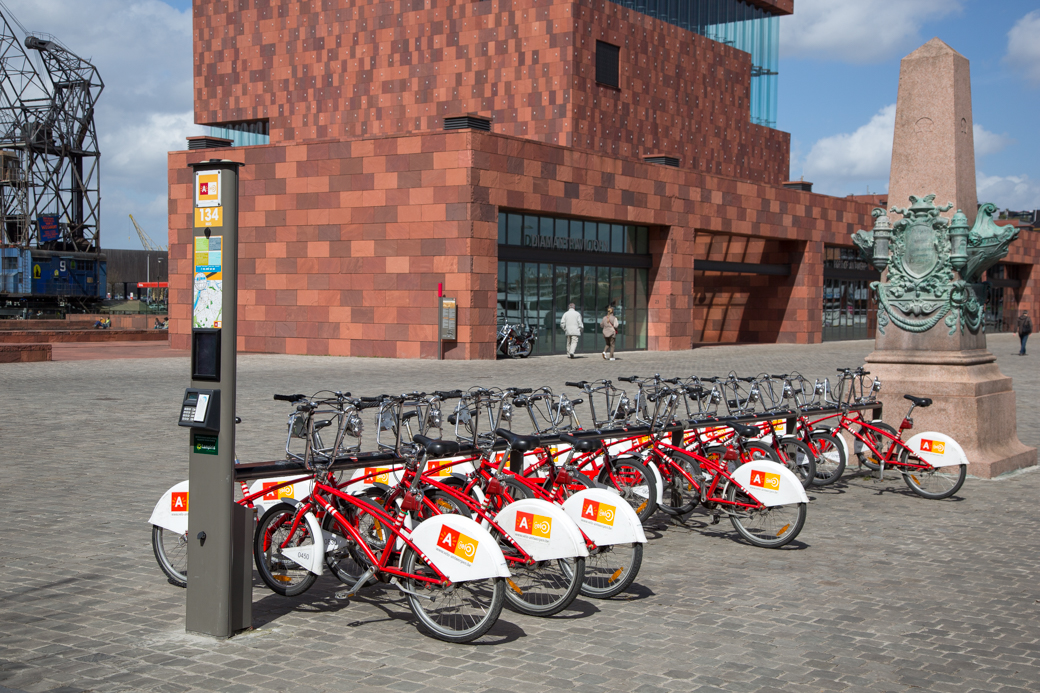

The company was impressed by the results you delivered in your first assignment; it wants to also hire you for analysis of their bike system in the other European city.

For this city, a good initial distribution of bikes may not be sufficient: They need more help with other aspects, e.g. with the actual operations of bike rebalancing. Assignment 2 (this assignment) as well as assignment 3 (the final assignment) will be centered around that.

Between these two assignments, asssignment 2 will focus purely on data analysis, in order to discover key system parameters like the true demand per location. Indeed, a key challenge for this system is that true demand is not always known because it may not always be registered. Since the bike rental locations are unmanned, it is non-trivial to work out the true demand for mobility at a location when that location is empty, as customers may choose an alternative mode of transportation in that case, and the demand remains unregistered.

Similarly, if a bike location is full, then it is difficult to figure out the true (/preferred) destination of customers, as they may go to a different destination that does have open spots and that allows for a drop-off.

You have received data on the bike location infrastructure. To load it, place the provided file `bike_locations_data.xlsx` in an appropriate subfolder on your google drive, and mount that drive like so:

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After succesfully mounting the drive, below code loads the data. Note that you may need to change the file_path, depending on where in google drive you stored the excel file. The data contains the coordinates of the various locations, as well as their capacity for holding bikes. (Note that each location has "slots" that can hold bikes, a bike cannot be dropped at a location when all slots are full, see e.g. the above photo. )

In [ ]:
import math
file_path = '/content/drive/My Drive/bike_locations_data.xlsx'

df = pd.read_excel(file_path)

class Location:
    def __init__(self, loc, x, y, cap):
        self.loc = loc
        self.x = x
        self.y = y
        self.cap = cap


    def distance(self, other):
        return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)
    def __repr__(self):
        return f"loc{self.loc}(x={self.x}, y={self.y}, capacity={self.cap})"
#this loads the data into the locations list
locations = [Location(loc=int(row['loc']), x=row['x'], y=row['y'], cap=row['cap']) for index, row in df.iterrows()]


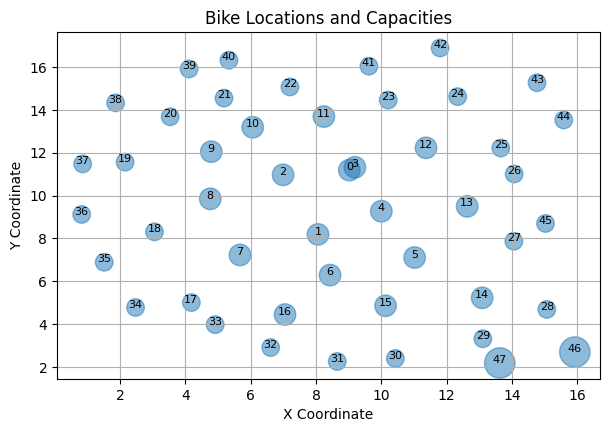

In [ ]:
#Let's create a quick figure to visualize the various locations with their
# location number, with the size of the dot representing the capacity, on a map.
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4.5))
scatter = plt.scatter(df['x'], df['y'], s=df['cap']*4, alpha=0.5)

for i, point in df.iterrows():
    plt.text(point['x'], point['y'], f"{int(point['loc'])}", fontsize=8, ha='center')
plt.title('Bike Locations and Capacities')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

Your final goal (for the final assignment 3 that you will receive later) will be to come up with bike rebalancing policies that will help the system to run more smoothly. For the present assignment 2, we work towards that goal by analyzing some data, to get a better idea of the true demand for mobility in the system.

To that end, you collected trip data from the system for 6 representative operating days, some of which were a bit more busy than others. Note that these were not consequtive days, and that the company engages in rebalancing, so for multiple reasons the starting inventory of one day need not match the ending inventory of the other day. The data is given in the form of rows containing information on trips:
* `oper_day`: an id (between 0 and 5) that connects to the day for which this data was collected. The data contains all trips that were started between 00:00 and 23:59 on the respective days.
* `wdr_loc`: where the bike was picked up - referring to the numbering in the location data above.
* `wdr_b`: number of bikes at the withdrawal location, just after this bike was withdrawn.
* `wdr_t`: time at which the bike was withdrawn (number representing the amount of hours after 00:00. I.e. 6.5 refers to 6 and a half hours after midnight, i.e. 06:30AM.)
* `ret_loc`: where the bike was returned.
* `ret_b`: number of bikes at the return location, just after this bike was returned.
* `ret_t`: time at which bike was returned (same encoding as `withdr_t`).

Below is some code that can load this data. To run it, you must first save the  mount the drive (see code in first code cell above):

In [ ]:
# Load the data from the Excel file - make sure the path corresponds to where
# saved the data
file_path = '/content/drive/My Drive/transactions_data.xlsx'

data = pd.read_excel(file_path)

# To obtain the data for each day separately, we group by the 'operating_day_id'
grouped_data = data.groupby('oper_day')

# Create a dictionary to store data for each day
daily_data = {day: group.drop(columns='oper_day') for day, group in grouped_data}

# Optionally, you can display the data for each day to check
#for day in daily_data:
#    print(f"Data for Day {day}:")
#    print(daily_data[day], "\n")


##Goals of data analysis

To test various approaches for operational rebalancing policies, it will be crucial to obtain an accurate estimate of various elements in the problem, especially the demand and travel times.

Of course, we could directly use the demand arising from the `transactions_data` lines, but note that there were some situations where certain bike locations ran out of stock.

In [ ]:
day_zero = daily_data[0]
#get the rows where no bikes were left after a withdrawal.
zero_withdrawn_bikes = day_zero[day_zero['wdr_b'] == 0]
print(f"Number of rows on day zero which involved the last bike being withdrawn: {zero_withdrawn_bikes.shape[0]}")
print(f"Total number of trips for day zero: {day_zero.shape[0]}")

Number of rows on day zero which involved the last bike being withdrawn: 554
Total number of trips for day zero: 8370


Now, when the last bike is withdrawn, and a new customer would arrive that would normally want to use a bike, then that customer cannot withdraw a bike and would typically choose a different mode of transport. So suppose the total number of withdrawals at a location over a day is 140. This does not need to imply that the total _demand_ was 140 - it may be higher and some people may have found different solutions for their mobility needs. This is mainly the case when a certain location stocks out completely for a period of time.

One goal of the data analysis is to recover the real demand from the data somehow. This will definitely involve estimates. A related goal will be to recover the true pattern of demand over the day, for each of the locations. Since transportation is a rather universal need, we might expect similar demand patterns for various locations, but some locations have a higher demand than others.

The goal of all this analysis is to develop a more accurate simulation model, that does not directly utilize past trip data, but actually estimates the true underlying demand per location, and converts this to a demand rate per time of day. In addition to the demand data for each origin, also the destination data needs to somehow be estimated.

A final ingredient would be travel times, which would likely involve a distance dependent estimation procedure. For purposes of estimating distances, you would normally use a solution like the google maps API. But for the purposes of this course, it is likely sufficient to simply use the Euclidean distance (there is a function provided in Location that can compute it allready) - it would in many cases, for medium to larger distances, have an approximately linear relationship with the distance over the road.

Note that with this information (amount of withdrawals per time of day per origin location + probability of destination locations + travel times) we would be able to make an event-driven simulation of the whole system (like we did in assignment 1). This will be the starting point for assignment 3 (the next assignment).

##Assignment


Please hand in the assignment by simply downloading the pynb file and submitting that in canvas. Add some text fields describing the choices that you made, and the main outcomes of the analysis:
1. An estimate of the demand pattern per hour of day, for each of the locations. I.e. what percentage of total demand on a day tends to happen for various hours of the day.
2. The average real daily demand per period for each of the locations, taking into account an estimate of the demand that is lost. Try to also add a variance estimate.
3. An estimate of destination probabilities for each origin location. I.e., considering that a bike is withdrawn from a specific location, what are the probabilities that the customer will want to return that bike to each of the 48 locations in the network?
4. An estimate of the travel time for each origin-destination pair. I.e., suppose a customer travels from location i to location j, what is the expected travel time and what standard deviation do you expect. Note that distance is expected to play a role here, and the amount of data for some trips is very limited?

When grading, we consider
* Did you clearly explain (in separate text cells) what analysis steps you took when determining each of the above estimates. (30%)
* How appropriate are the various steps taken? What approach did you take to estimate the true daily demand? Did you do anything smart to resolve that only relatively limited data on travel times is available for some of the origin-destination pairs? (25%)
* Is your code clear? Does it work - can we easily run all cells and get the answers we would expect. (20%)
* Are the final results clearly presented? Are some helpfull figures included? (25%)

To make the code readable, we suggest that you tackle the four estimation questions one by one, explaining in each case what you did and why.

## Demand Patterns
The approach begins with analyzing the withdrawal data for Day 0 to extract meaningful insights about demand patterns. By converting the withdrawal times into hourly intervals, the data is grouped by location and time, providing a detailed view of how demand varies throughout the day. This method normalizes withdrawals to reflect the percentage of total demand for each hour, rather than just raw numbers. This ensures comparisons can be made across locations with different levels of traffic or capacity. Plotting the demand patterns for each location allows for visualization of peak times and trends, offering a comprehensive understanding of demand fluctuations. This data-driven and practical approach enables better prediction of demand at specific times and informs future bike allocation strategies.

In [ ]:
# Some code with annotations
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load and Prepare the Data ---

day_zero = daily_data[0]  # Data for Day 0

# --- Step 2: Extracting Hour from Withdrawal Time , convert it to the nearest hour
day_zero['wdr_hour'] = day_zero['wdr_t'].apply(lambda x: int(x))

# --- Step 3: Count Withdrawals per Hour per Location
withdrawals_by_hour = day_zero.groupby(['wdr_loc', 'wdr_hour'])['wdr_b'].count().unstack(fill_value=0)

# --- Step 4: Calculate Total Withdrawals per Location ---
total_withdrawals_per_location = withdrawals_by_hour.sum(axis=1)

# --- Step 5: Normalize Withdrawals to Get Percentage of Total Demand per Hour
normalized_withdrawals_by_hour = withdrawals_by_hour.divide(total_withdrawals_per_location, axis=0) * 100

# --- Step 6: Plot Demand Pattern for Each Location, Each location's demand pattern will be plotted in a separate figure for clarity.

for location_id in withdrawals_by_hour.index:
    location_demand_pattern = normalized_withdrawals_by_hour.loc[location_id]

    plt.figure(figsize=(10, 6))
    plt.plot(location_demand_pattern.index, location_demand_pattern.values,
             label=f'Demand Pattern for Location {location_id}', marker='o', color='b')

    plt.title(f'Demand Pattern for Location {location_id}', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Percentage of Total Daily Demand', fontsize=14)

    plt.xticks(range(24), rotation=45)

    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    plt.axhline(0, color='gray', linewidth=0.8)

    plt.tight_layout()
    plt.legend()
    plt.show()


# a final graph showing the result for a typical location.
# note that the pattern should be computed for all locations, but for graphs,
# it is sufficient to focus on one location.

Output hidden; open in https://colab.research.google.com to view.

## Real daily demand

**Explanation of the approach taken:**


The approach taken was calculating the average hourly withdrawals for each station. When a station was out of stock, we estimated the lost demand by multiplying the average hourly withdrawal rate by the time that  the station was out of stock. This gave us an estimate of the demand that was not met. In the end, by adding this estimated lost demand to the observed demand, we estimated the total real demand for each station.

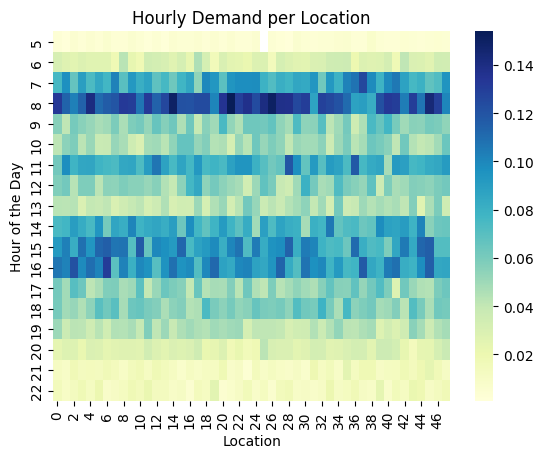

In [ ]:
#some code
import seaborn as sns
daily_demand = data.groupby(['oper_day', 'wdr_loc']).size().reset_index(name = 'withdrawals')
demand = daily_demand.groupby('wdr_loc')['withdrawals'].agg(['mean', 'var', 'std']).reset_index()

# identifying the bike stations that ran out of stock
out_of_stock = data[data['wdr_b'] == 0].copy()

#calculating the average hourly withdrawal to estimate how many customers wanted to rent a bike at a location when it was out of stock
hourly_demand = data.groupby(['wdr_loc', data['wdr_t'].astype(int)]).size()
hourly_average = hourly_demand.groupby('wdr_loc').mean()

# estimating the lost demand for each bike station
def getting_lost_demand(loc):
    return hourly_average.get(loc, 0)

out_of_stock['lost_demand'] = out_of_stock['wdr_loc'].apply(getting_lost_demand)
lost_demand = out_of_stock.groupby(['oper_day', 'wdr_loc'])['lost_demand'].sum()

# counting the number of transactions per each station
hourly_pattern = data.groupby(['wdr_loc', data['wdr_t'].astype(int)]).size()
hourly_pattern = hourly_pattern.reset_index(name = 'count')

# calcualting the demand for each station by summing up the hourly transactions
total_demand_per_location = hourly_pattern.groupby('wdr_loc')['count'].transform('sum')
hourly_pattern['percentage'] = hourly_pattern['count'] / total_demand_per_location

# merging the observed demand and the lost demand
total_demand = daily_demand.merge(lost_demand, on = ['oper_day', 'wdr_loc'])

# filling the Na values with zeroes
total_demand['lost_demand'] = total_demand['lost_demand'].fillna(0)

# adding up the values of the observed demand and the lost demand to recieve the real demand
total_demand['total_demand'] = total_demand['withdrawals'] + total_demand['lost_demand']

# additional statistical analysis of the real demand of each station
total_demand_statistics = total_demand.groupby('wdr_loc')['total_demand'].agg(['mean', 'var', 'std'])
# print(total_demand_statistics)

#some figures illustrating the approach
table = hourly_pattern.pivot(index = 'wdr_t', columns = 'wdr_loc', values = 'percentage')
sns.heatmap(table, cmap = "YlGnBu")
plt.title("Hourly Demand per Location")
plt.xlabel("Location")
plt.ylabel("Hour of the Day")
plt.show()

## destination probabilities

The methodology here systematically quantifies the likelihood of bike returns from each origin location to any given destination. First, trips are grouped by origin (wdr_loc) and destination (ret_loc) and the frequency of each origin-destination pair is calculated. This is followed by normalizing the trip counts by the total number of trips from each origin, which provides destination probabilities. The result is a probability matrix that represents the likelihood of a bike being returned to any destination given it was withdrawn from a specific origin. To aid interpretation, this matrix is visualized using a heatmap, offering an efficient way to identify patterns and relationships in the data. This approach minimizes assumptions, uses clear data transformations, and allows for a quantitative, objective analysis of destination trends.

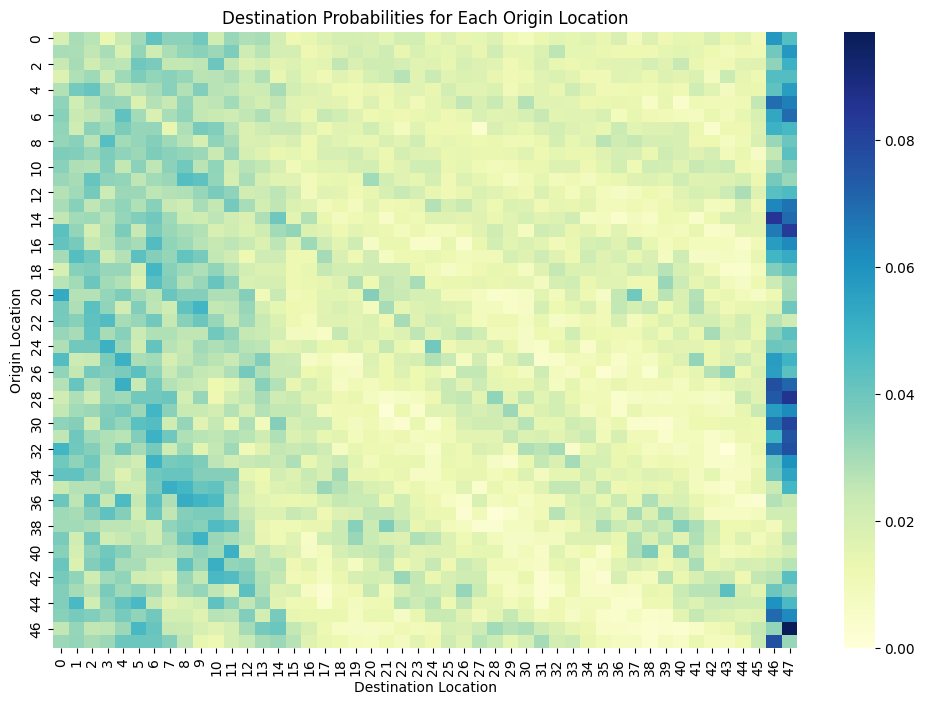

Destination Probabilities for Each Origin Location:
ret_loc        0         1         2         3         4         5         6   \
wdr_loc                                                                         
0        0.019126  0.029372  0.026639  0.012978  0.023224  0.030738  0.042350   
1        0.029518  0.028798  0.025198  0.029518  0.018719  0.033117  0.021598   
2        0.023944  0.029577  0.021831  0.026761  0.026056  0.039437  0.037324   
3        0.017325  0.028413  0.031185  0.022176  0.031185  0.036729  0.033264   
4        0.027926  0.038564  0.041223  0.029920  0.023271  0.027261  0.029920   
5        0.034000  0.021333  0.027333  0.032667  0.032000  0.018000  0.027333   
6        0.035019  0.023346  0.025292  0.028534  0.042802  0.030480  0.018807   
7        0.033476  0.022080  0.034188  0.030627  0.037037  0.032764  0.032764   
8        0.032631  0.034670  0.027192  0.044188  0.030591  0.032631  0.035350   
9        0.036620  0.035915  0.032394  0.036620  0.033803

In [ ]:
# Grouping by origin (wdr_loc) and destination (ret_loc) and count trips
origin_destination_counts = data.groupby(['wdr_loc', 'ret_loc']).size().reset_index(name='trip_count')

# Calculating total trips from each origin
total_trips_per_origin = origin_destination_counts.groupby('wdr_loc')['trip_count'].transform('sum')

# Normalising to get destination probabilities
origin_destination_counts['destination_probability'] = origin_destination_counts['trip_count'] / total_trips_per_origin

# Pivot the data to create a matrix of origin vs destination probabilities
probability_matrix = origin_destination_counts.pivot(index='wdr_loc', columns='ret_loc', values='destination_probability').fillna(0)

# Visualising the probabilities using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(probability_matrix, cmap="YlGnBu", annot=False)
plt.title("Destination Probabilities for Each Origin Location")
plt.xlabel("Destination Location")
plt.ylabel("Origin Location")
plt.show()

#Display the table of destination probabilities
print("Destination Probabilities for Each Origin Location:")
print(probability_matrix)


## travel time estimates

**Explanation of the approach taken:**

At first we visualise the travel time vs distance data in order to see if the data is linear. Eventually we find ou it is, and therefore we can use a Linear regression model to predict the travel time for the trips that have missing values (we believe that it is best to leave the observed travel time values as it is more accurate, therefore the model predicts all of the values, but we add only the NaN tavel time values to the final dataframe). After creating the model, we fill in the values of the travel time and have a complete data set.

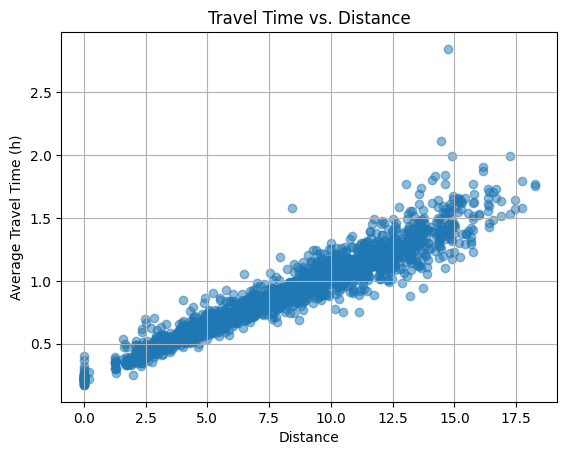

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


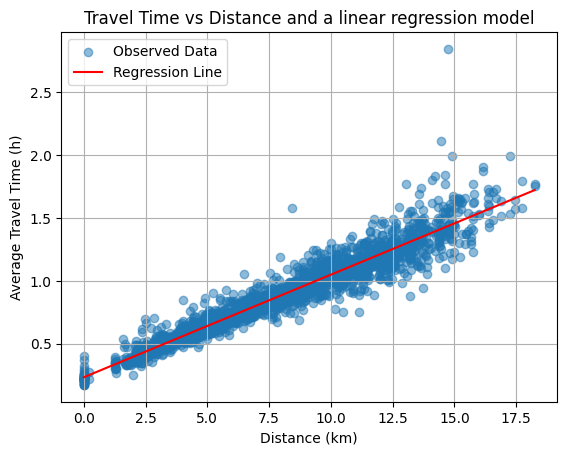

In [ ]:
# Some code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# we are creating the locations dictionary, becuase it will be easier and quicker to find the values that we need
locations_dict = {row['loc']: (row['x'], row['y']) for _, row in df.iterrows()}

# we are going to use Euclidean distance as the traveled distance
def calculate_distance(origin, destination):
  """
  This function takes the coordinates of each origin station and destination station and calculates the distance between them.
  """
  x1, y1 = locations_dict[origin]
  x2, y2 = locations_dict[destination]
  return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# we are adding the calculated distances to each row in the data frame
data['distance'] = data.apply(lambda row: calculate_distance(row['wdr_loc'], row['ret_loc']), axis = 1)

# now we are calculating the real travel time
data['travel_time'] = data['ret_t'] - data['wdr_t']

# calculating the mean and standard deviation of the travel time to
travel_time_stats = data.groupby(['wdr_loc', 'ret_loc'])['travel_time'].agg(['mean', 'std']).reset_index()
travel_time_stats = travel_time_stats.rename(columns = {'mean': 'average_travel_time', 'std': 'standard_deviation_of_travel_time'})

# filling in all the NaN values with zeroes to avoid missing values
travel_time_stats['standard_deviation_of_travel_time'] = travel_time_stats['standard_deviation_of_travel_time'].fillna(0)

# print(travel_time_stats.head())

# adding the distance data to the travel_time_stats dataframe
travel_time_stats['distance'] = travel_time_stats.apply(lambda row: calculate_distance(row['wdr_loc'], row['ret_loc']), axis = 1)

# some support for the approach taken

# thanks to the scatterplot we can see that the data is quite linear, and therefore we could estimate the travel time using linear regression
plt.scatter(travel_time_stats['distance'], travel_time_stats['average_travel_time'], alpha = 0.5);
plt.title("Travel Time vs. Distance")
plt.xlabel("Distance")
plt.ylabel("Average Travel Time (h)")
plt.grid(True)
plt.show()

# the final approach and results

# preparing data
train_data = travel_time_stats.dropna(subset = ['average_travel_time', 'distance'])

# defining the independent (X - distance) and dependent (Y - travel time) variables
X = train_data[['distance']]
y = train_data['average_travel_time']

# creating a linear regression model
model = LinearRegression()

# fitting the model to the variables
model.fit(X, y)

# adding travel time predicted by the model to the dataframe with travel time statistics
travel_time_stats['predicted_travel_time'] = model.predict(travel_time_stats[['distance']])

# filling in the NaN values with the values predicted by the model (we want to leave the original travel time if it was registered, becuase it is more accurate)
travel_time_stats['final_travel_time'] = travel_time_stats['average_travel_time'].fillna(travel_time_stats['predicted_travel_time'])

# calculating the mean standard deviation of travel time
mean_standard_deviation = travel_time_stats['standard_deviation_of_travel_time'].mean()

# adding the standard deviation to the travel_time_stats dataframe
travel_time_stats['final_standard_deviation'] = travel_time_stats['standard_deviation_of_travel_time'].fillna(mean_standard_deviation)

# visualising the regression model
plt.scatter(train_data['distance'], train_data['average_travel_time'], alpha=0.5, label='Observed Data');
x_line = np.linspace(0, train_data['distance'].max(), 100)
y_line = model.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color = 'red', label = 'Regression Line')

plt.title("Travel Time vs Distance and a linear regression model")
plt.xlabel("Distance (km)")
plt.ylabel("Average Travel Time (h)")
plt.legend()
plt.grid(True)
plt.show()